# TSNE
<img src="https://lvdmaaten.github.io/tsne/examples/mnist_tsne.jpg" style="height:400px">

TSNE is a wonderful and surprisingly effective dimensionality reduction algorithm that finds information in high dimensional data through minimising the Kullback Leiback Divergence between the probabilities in the full data space and the reduced space.

In the original high dimensional space, each point's probability of occurence are:

$$ P_{ij} = \frac{exp(-||x_i - x_j||^2 / 2 \sigma_i^2)}{\sum exp(-||x_i - x_k||^2 / 2 \sigma_i^2)} $$

In the lower embedding space, each point's probability is:

$$ Q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum (1 + ||y_k - y_l||^2)^{-1}} $$

We want to minimise the KL Divergence between $ P_{ij} $ and $ Q_{ij} $ so:

$$ J(Y) = KL(P || Q) = \sum p_{ij} log(\frac{p_{ij}}{q_{ij}}) $$

By splitting the gradient updates to attractive and repulsive forces we get the gradient updates:

$$ \frac{dJ}{dy_i} = F_{attract_i} - Z F_{repel_i} $$

$$ F_{attract_i} = \sum p_{ij} q_{ij} Z (y_i - y_j) $$

$$ F_{repel_i} = \sum q_{ij}^2 Z (y_i - y_j) $$

cuML TSNE applies some cool optimizations to calculate both $ F_{attract_i} $ and $ F_{repel_i} $, which are described at the very bottom of this notebook!

In [1]:
from cuml.manifold import TSNE as cuml_TSNE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cuml_tsne = cuml_TSNE(method = 'barnes_hut', n_neighbors = 30, learning_rate = 20000, early_exaggeration = 24, perplexity = 30,
                     n_components = 2)
cuml_tsne

TSNE(n_components=2, perplexity=30.0, early_exaggeration=24.0, learning_rate=20000.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1.0000000116860974e-07, metric='euclidean', init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5, learning_rate_method='adaptive', n_neighbors=30, perplexity_max_iter=100, exaggeration_iter=250, pre_momentum=0.5, post_momentum=0.800000011920929, handle=<cuml.common.handle.Handle object at 0x7f7870651f00>)

In [4]:
from sklearn.manifold import TSNE
sklearn_tsne = TSNE()
sklearn_tsne

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=0)

# MNIST digits
MNIST is the "dataset of all datasets", where all algorithms should be tested on! TSNE does surprisingly well on MNIST, showcasing how each digit has been separated into noticeable clusters.

Notice - TSNE was given no information on which digits belong to which class!!! Clearly TSNE has clustered the data into well defined structure.

In [5]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X = x_train.reshape((60000,28**2)).astype(np.float32)
y = y_train

Let's check out some of the digits!

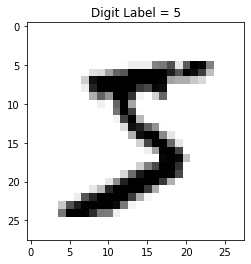

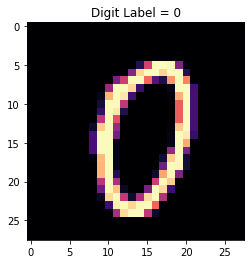

In [6]:
plt.imshow(X[0].reshape(28, 28), cmap = 'binary')
plt.title('Digit Label = {}'.format(y[0]))
plt.show()
plt.imshow(X[1000].reshape(28, 28), cmap = 'magma')
plt.title('Digit Label = {}'.format(y[1000]))
plt.show()

Let's now apply TSNE and see the result!

CPU times: user 2.31 s, sys: 876 ms, total: 3.19 s
Wall time: 3.2 s


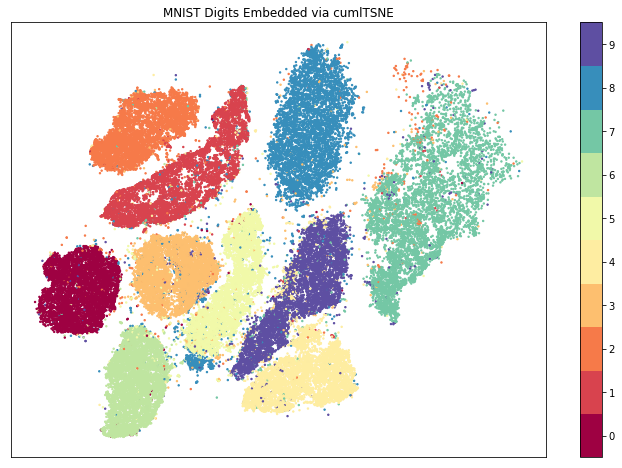

In [7]:
%time Y = cuml_tsne.fit_transform(X)

fig, ax = plt.subplots(1, figsize = (12, 8))
plt.scatter(Y[:,1], Y[:,0], s = 2, c = y, cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.title('MNIST Digits Embedded via cumlTSNE')
plt.show()

We also try using Sklearn. You might have to wait a while...

You can see on n = 60,000, cuML's TSNE manages to finish in roughly 3.3 **SECONDS**, whilst Sklearn takes an unfortunately long amount of time (1 **HOURS** and 15 minutes). To make you not have to impatient, we subsampled a small 1000 points...

Even on a small 1000 points, Sklearn takes roughly 6.5 seconds....

Using the speedup formula of $ Speedup = \frac{Old Time}{New Time}$

cuML's speedup is:

In [14]:
speedup = 75 / (3.3 / 60)  # 75 minutes / (3.3/60) minutes

print("CuML Speedup is = {}".format(speedup))

CuML Speedup is = 1363.6363636363637


CPU times: user 6.6 s, sys: 20 ms, total: 6.62 s
Wall time: 6.6 s


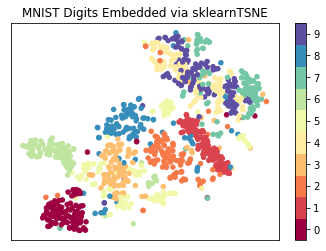

In [15]:
rand = np.random.choice(X.shape[0], size = 1000, replace = 0)
%time Y = sklearn_tsne.fit_transform(X[rand])

fig, ax = plt.subplots(1, figsize = (6, 4))
plt.scatter(Y[:,1], Y[:,0], s = 20, c = y[rand], cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.title('MNIST Digits Embedded via sklearnTSNE')
plt.show()

# Fashion MNIST
Another popular dataset is Fashion MNIST. Instead of having 10 classes of digits, Fashion MNIST has 10 classes as listed below:

In [43]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X = x_train.reshape((60000,28**2)).astype(np.float32)
y = y_train

classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

Let's showcase some of the data in Fashion MNIST!

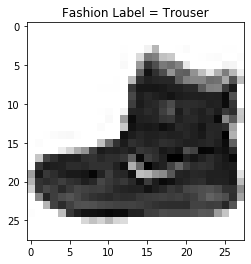

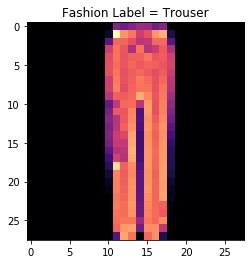

In [44]:
plt.imshow(X[0].reshape(28, 28), cmap = 'binary')
plt.title('Fashion Label = {}'.format(classes[y[1000]]))
plt.show()
plt.imshow(X[1000].reshape(28, 28), cmap = 'magma')
plt.title('Fashion Label = {}'.format(classes[y[1000]]))
plt.show()

Now let's use TSNE to reduce the dimensions to 2!

CPU times: user 2.25 s, sys: 896 ms, total: 3.15 s
Wall time: 2.22 s


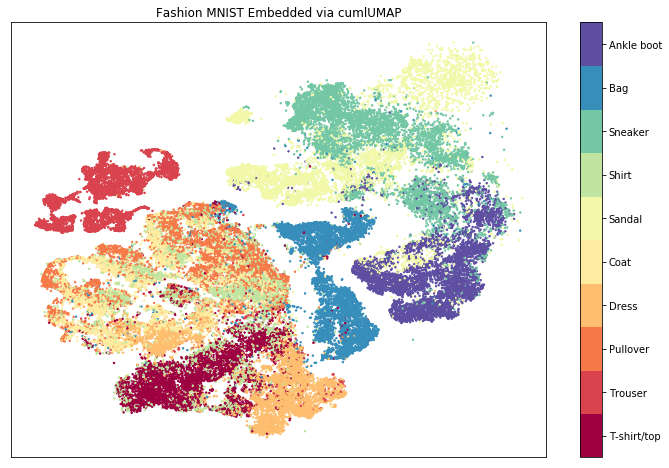

In [19]:
%time Y = cuml_tsne.fit_transform(X)

fig, ax = plt.subplots(1, figsize = (12, 8))
plt.scatter(Y[:,1], Y[:,0], s = 2, c = y, cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlUMAP');

CPU times: user 1.16 s, sys: 160 ms, total: 1.32 s
Wall time: 403 ms


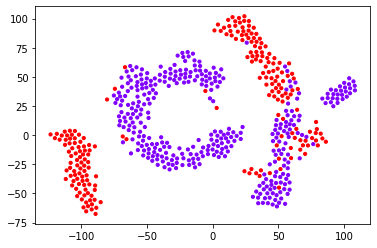

In [45]:
from sklearn.datasets import load_breast_cancer as data
X, y = data().data, data().target

%time Y = cuml_tsne.fit_transform(X)
plt.scatter(Y[:,0], Y[:,1], c = y, s = 10, cmap = 'rainbow_r')